In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
import sys
sys.path.append('../')
from movielens.preprocessing.cleaner import DataCleaner
from movielens.config import *

In [3]:
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
cleaner = DataCleaner()

try:
    ratings_df, movies_df, tags_df = cleaner.load_data()
    print(f"✅ Datasets have been downloaded:")
    print(f"   - ratings: {len(ratings_df):,} records")
    print(f"   - movies: {len(movies_df):,} records")
    print(f"   - tags: {len(tags_df):,} records")
except FileNotFoundError as e:
    print(f"❌ error: {e}")
    print("Please download the datasets")
    print("python scripts/prepare_data.py")

Output()

Loaded 20000263 ratings

Loaded 27278 movies

Loaded 465564 tags

✅ Datasets have been downloaded:
   - ratings: 20,000,263 records
   - movies: 27,278 records
   - tags: 465,564 records


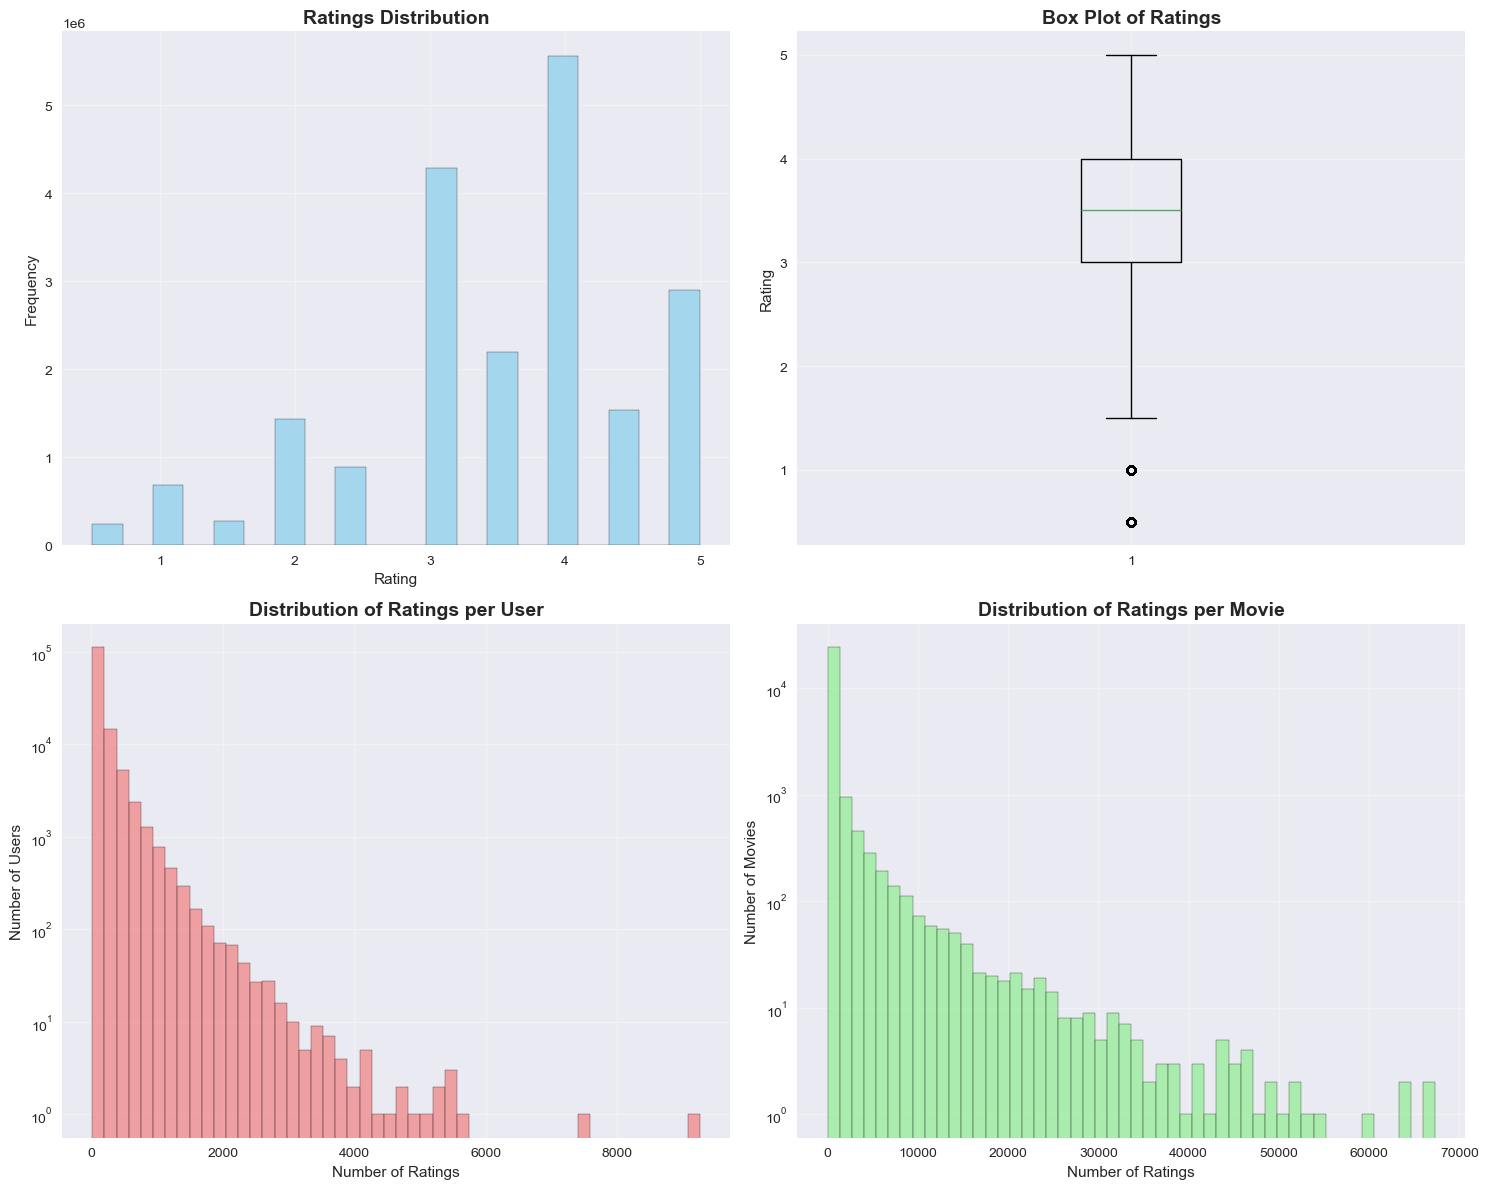


📈 Descriptive Statistics of Ratings:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogram
axes[0,0].hist(ratings_df['rating'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title("Ratings Distribution", fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Box plot
axes[0,1].boxplot(ratings_df['rating'])
axes[0,1].set_title('Box Plot of Ratings', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Rating')
axes[0,1].grid(True, alpha=0.3)

# Distribution of ratings per user
user_rating_counts = ratings_df['userId'].value_counts()
axes[1,0].hist(user_rating_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_title('Distribution of Ratings per User', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Number of Ratings')
axes[1,0].set_ylabel('Number of Users')
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)

# Distribution of ratings per movie
movie_rating_counts = ratings_df['movieId'].value_counts()
axes[1,1].hist(movie_rating_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].set_title('Distribution of Ratings per Movie', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Number of Ratings')
axes[1,1].set_ylabel('Number of Movies')
axes[1,1].set_yscale('log')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\n📈 Descriptive Statistics of Ratings:")
print(ratings_df['rating'].describe())

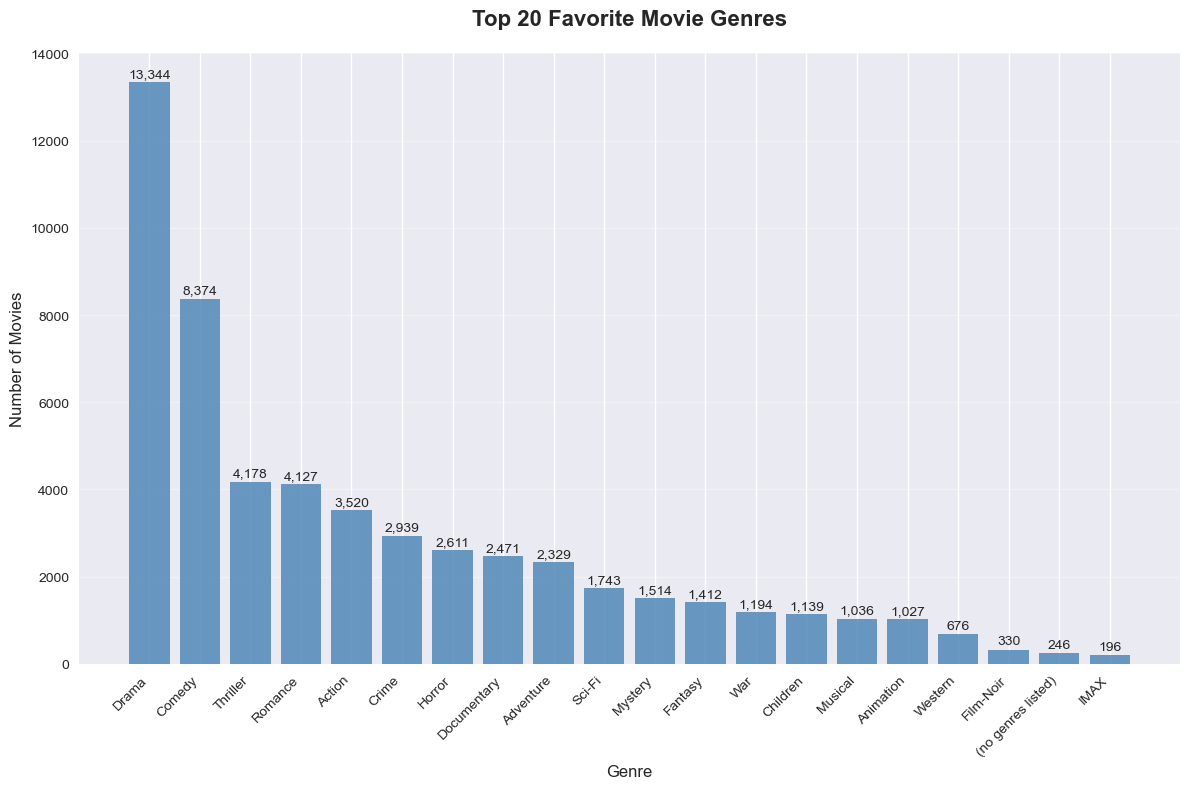


🎭 Genre Statistics:
  • Total unique genres: 20
  • Most popular genre: Drama (13,344 movies)
  • Least popular genre: IMAX (196 movies)


In [6]:
all_genres = []
for genres in movies_df['genres']:
    if pd.notna(genres):
        all_genres.extend(genres.split('|'))

genre_counts = pd.Series(all_genres).value_counts()

# plot of favorite movies
plt.figure(figsize=(12, 8))
top_20_genres = genre_counts.head(20)
bars = plt.bar(range(len(top_20_genres)), top_20_genres.values, 
               color='steelblue', alpha=0.8)

plt.title('Top 20 Favorite Movie Genres', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(range(len(top_20_genres)), top_20_genres.index, rotation=45, ha='right')

# Adding values on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\n🎭 Genre Statistics:")
print(f"  • Total unique genres: {len(genre_counts)}")
print(f"  • Most popular genre: {genre_counts.index[0]} ({genre_counts.iloc[0]:,} movies)")
print(f"  • Least popular genre: {genre_counts.index[-1]} ({genre_counts.iloc[-1]:,} movies)")

In [7]:
# changing timestamp to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_df['month'] = ratings_df['timestamp'].dt.month
ratings_df['hour'] = ratings_df['timestamp'].dt.hour

# analyzing passage of time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# yearly ratings trend
yearly_ratings = ratings_df['year'].value_counts().sort_index()
axes[0,0].plot(yearly_ratings.index, yearly_ratings.values, marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('Yearly Ratings Trend', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Ratings')
axes[0,0].grid(True, alpha=0.3)

# monthly ratings trend
monthly_ratings = ratings_df['month'].value_counts().sort_index()
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
axes[0,1].bar(monthly_ratings.index, monthly_ratings.values, color='orange', alpha=0.7)
axes[0,1].set_title('Monthly Ratings Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Ratings')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].grid(True, alpha=0.3, axis='y')

# hourly ratings trend
hourly_ratings = ratings_df['hour'].value_counts().sort_index()
axes[1,0].bar(hourly_ratings.index, hourly_ratings.values, color='green', alpha=0.7)
axes[1,0].set_title('Hourly Ratings Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Number of Ratings')
axes[1,0].grid(True, alpha=0.3, axis='y')

# mean of rating over years
yearly_avg_rating = ratings_df.groupby('year')['rating'].mean()
axes[1,1].plot(yearly_avg_rating.index, yearly_avg_rating.values, 
               marker='s', linewidth=2, markersize=4, color='red')
axes[1,1].set_title('Average Ratings Over the Years', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Rating')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ValueError: non convertible value 2005-04-02 23:53:47 with the unit 's', at position 0